In [26]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import json
with open("./drive/My Drive/Datasets/ChatBot/intents.json") as file:
    data = json.load(file)
data  #correctly loads

{'intents': [{'context_set': '',
   'patterns': ['Hi',
    'How are you',
    'Is anyone there?',
    'Hello',
    'Good day',
    'Whats up'],
   'responses': ['Hello!',
    'Good to see you again!',
    'Hi there, how can I help?'],
   'tag': 'greeting'},
  {'context_set': '',
   'patterns': ['cya',
    'See you later',
    'Goodbye',
    'I am Leaving',
    'Have a Good day'],
   'responses': ['Sad to see you go :(', 'Talk to you later', 'Goodbye!'],
   'tag': 'goodbye'},
  {'context_set': '',
   'patterns': ['how old',
    'how old is tim',
    'what is your age',
    'how old are you',
    'age?'],
   'responses': ['I am 18 years old!', '18 years young!'],
   'tag': 'age'},
  {'context_set': '',
   'patterns': ['what is your name',
    'what should I call you',
    'whats your name?'],
   'responses': ['You can call me Tim.',
    "I'm Tim!",
    "I'm Tim aka Tech With Tim."],
   'tag': 'name'},
  {'context_set': '',
   'patterns': ['Id like to buy something',
    'whats on the men

In [28]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:

import numpy
import random
import json
import pickle

from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

def distributeData(data):

  vocabulary = []
  labels = []
  question = []
  responses = []

  for intent in data["intents"]:
      for pattern in intent["patterns"]:
          wrds = nltk.word_tokenize(pattern)
          vocabulary.extend(wrds)
          question.append(wrds)
          responses.append(intent["tag"])

      if intent["tag"] not in labels:
          labels.append(intent["tag"])

  vocabulary = [stemmer.stem(w.lower()) for w in vocabulary if w != "?"]
  vocabulary = sorted(list(set(vocabulary)))

  labels = sorted(labels)
  return vocabulary, labels,question, responses

vocabulary, labels, question, responses = distributeData(data)

def createTrainingData():
  training = []
  output = []

  out_empty = [0 for _ in range(len(labels))]

  for x, doc in enumerate(question):
      bag = []

      wrds = [stemmer.stem(w.lower()) for w in doc]

      for w in vocabulary:
          if w in wrds:
              bag.append(1)
          else:
              bag.append(0)

      output_row = out_empty[:]
      output_row[labels.index(responses[x])] = 1

      training.append(bag)
      output.append(output_row)

  training = numpy.array(training)
  output = numpy.array(output)
  return training, output

training, output = createTrainingData()


with open("./drive/My Drive/Datasets/ChatBot/data.pickle", "wb") as f:
    pickle.dump((vocabulary, labels, training, output), f)

In [31]:

with open("./drive/My Drive/Datasets/ChatBot/data.pickle", "rb") as f:
  words, labels, training, output = pickle.load(f)

print(words)
print(len(words))
print(labels)
print(len(labels))
print(training)
print(training.shape)
#print(output)
print(output.shape)

['a', 'ag', 'am', 'anyon', 'ar', 'buy', 'cal', 'could', 'cya', 'day', 'do', 'eat', 'get', 'good', 'goodby', 'guy', 'hav', 'hello', 'hi', 'hour', 'how', 'i', 'id', 'is', 'lat', 'leav', 'lik', 'menu', 'nam', 'of', 'old', 'on', 'op', 'reccommend', 'see', 'should', 'someth', 'the', 'ther', 'tim', 'to', 'up', 'what', 'when', 'yo', 'you']
46
['age', 'goodbye', 'greeting', 'hours', 'name', 'shop']
6
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]
(26, 46)
(26, 6)


In [ ]:
#Dependencies

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(8, input_dim=len(training[0]), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(len(output[0]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.CategoricalCrossentropy()])
history = model.fit(training, output, epochs=1000, verbose=1)

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'categorical_crossentropy'])

In [ ]:
history.history['loss']

In [50]:
def bag_of_words(s, words):
    bag = [0 for _ in range(len(words))]

    s_words = nltk.word_tokenize(s)
    s_words = [stemmer.stem(word.lower()) for word in s_words]

    for se in s_words:
        for i, w in enumerate(words):
            if w == se:
                bag[i] = 1
            
    return numpy.array(bag)


def chat():
    print("Start talking with the bot (type quit to stop)!")
    while True:
        inp = input("You: ")
        if inp.lower() == "quit":
            break

        q = [bag_of_words(inp, vocabulary)]
        q =numpy.array(q)
        #print(q.shape)
        results = model.predict(q)
        results_index = numpy.argmax(results)
        tag = labels[results_index]

        for tg in data["intents"]:
            if tg['tag'] == tag:
                responses = tg['responses']

        print(random.choice(responses))

chat()

Start talking with the bot (type quit to stop)!
You: how are you?
Hi there, how can I help?
You: What is your name
You can call me Tim.
You: Whats on the menus
Cookies are on the menu!
You: when are you open
We are open 7am-4pm Monday-Friday!
You: quit


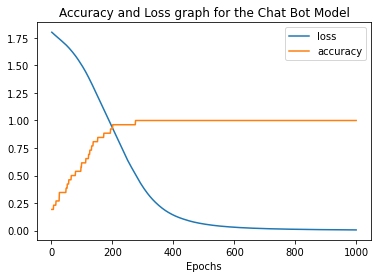

In [57]:
import matplotlib.pyplot as plt
losses = history.history['loss']
accuracies = history.history['accuracy']
x = [i+1 for i in range(1000)]
plt.plot(x, losses, label = "loss")
plt.plot(x, accuracies, label = "accuracy")
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Accuracy and Loss graph for the Chat Bot Model')
plt.legend()
plt.show()